## Introduction

The aim of this notebook is to get familiar with **Mixture of Gaussians** models.
 

We will use the Peterson and Barney’s dataset of vowel formant frequencies. (For more info, look at Classification of Peterson & Barney’s vowels using Weka.)

More specifically, Peterson and Barney measured the fundamental frequency $F0$ and the first three formant frequencies ($F1-F3$) of sustained English Vowels, using samples from various speakers.


In [1]:
import os

import pandas as pd
import numpy as np 
import scipy 

from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.cluster import KMeans 

import matplotlib.pyplot as plt 
 
from IPython import display
%matplotlib inline

In [2]:
data_npy_file = 'PB_data.npy'

data = np.load(data_npy_file, allow_pickle=True)
data = np.ndarray.tolist(data) # contains the phoneme ID (1-10) of each sample

pd.DataFrame(data)

,f3,f2,f1,f0,phoneme_id
0,2850,2280,240,160,1
1,2790,2400,280,186,1
2,2640,2030,390,203,2
3,2550,1980,310,192,2
4,2420,1870,490,161,3
...,...,...,...,...,...
1515,3400,1550,610,322,8
1516,3460,1250,520,345,9
1517,3380,1140,500,334,9
1518,2160,1850,740,308,10


The dataset contains 4 vectors ($F0-F3$), containing the fundamental frequencies ($F0$, $F1$, $F2$ and $F3$) for each phoneme and another vector “phoneme\_id” containing a number representing the id of the phoneme.

We will investigate fundamental frequencies  $F1$ and $F2$.

**Note**: Phonemes and Frequencies are two different things; phoneme_id is the ground truth class of each row while frequencies represent features of each data point.  

In [3]:
phoneme_id = data['phoneme_id']

# frequencies f1 and f2
f1 = data['f1']
f2 = data['f2']

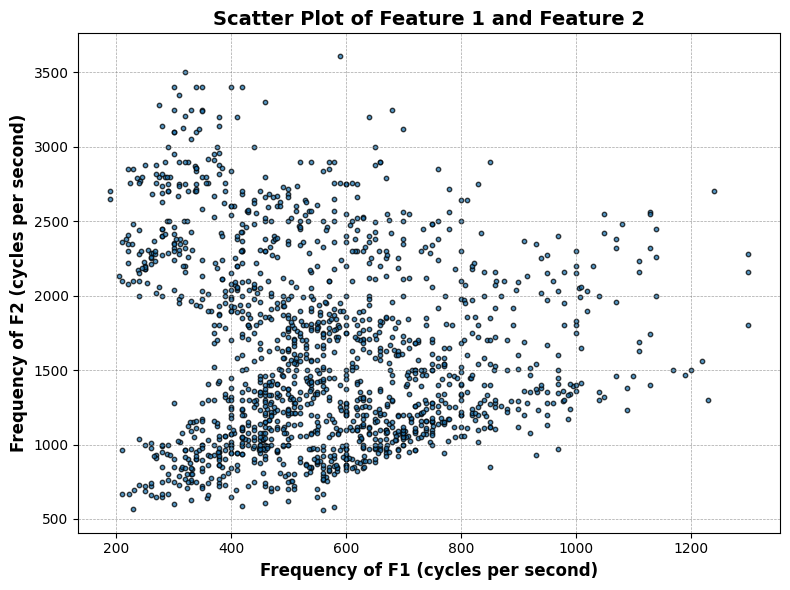

In [4]:
 
plt.figure(figsize=(8, 6))   
plt.scatter(f1,f2,   edgecolor='black', s=10, alpha=0.75) 
plt.xlabel("Frequency of F1 (cycles per second)", fontsize=12, fontweight='bold')
plt.ylabel("Frequency of F2 (cycles per second)", fontsize=12, fontweight='bold')
plt.title("Scatter Plot of Feature 1 and Feature 2", fontsize=14, fontweight='bold')

 
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
 
plt.tight_layout()   
plt.show()

# 1. MoG Using the EM algorithm

Definition of a Mixture of Gaussians. Assuming our observed random vector is $\mathbf{x}\in\mathbb{R}^D$, a MoG models $p(\mathbf{x})$ as a sum of $K$-many weighted Gaussians. More specifically:


\begin{equation}
 p(\mathbf{x}) = \sum_{k=1}^K \frac{p(c_{k})}{(2\pi)^{D/2} \mathrm{det}\left(\boldsymbol\Sigma_k\right)^{1/2}}
 % \exp(-\frac{1}{2}(x-\mu)^T \sum_{k}^{-1}(x-\mu))
 \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_k)^\top {\boldsymbol\Sigma_k}^{-1}(\mathbf{x}-\boldsymbol\mu_k)\right),
\end{equation}
where:
* $\boldsymbol\mu_k\in\mathbb{R}^{D}$
* $\boldsymbol\Sigma_{k}\in\mathbb{R}^{D\times D}$
* $p(c_{k})=\pi_k\in\mathbb{R}$

denote the $k$-th gaussian component's **mean vector**, **covariance matrix**, and **mixture coefficients** respectively. The $K$-many gaussian components' model parameters are referred to collectively as $\theta = \{\boldsymbol\mu_k,\boldsymbol\Sigma_{k},\pi_k\}_{k=1}^K$.

## EM Algorithm
For the E step we softly assign each datum to the closest centroid (using the current iteration's fixed model parameters) as in the K means example.

For the M step we update the model parameters $\theta$ to maximize the weighted log-likelihood.
At a high level, for each centroid k we:
* Update the mean vectors
* Update the covariance matrices (We will fit Gaussians with diagonal covariance matrices)
* Set the mixture coefficients as the mean probability of a sample being generated by the k-th gaussian component

In [5]:
def get_predictions(mu, s, p, X):
	"""
		:param mu			: means of GMM components
		:param s			: covariances of GMM components
		:param p 			: weights of GMM components
		:param X			: 2D array of our dataset
	"""

	# get number of GMM components
	k = s.shape[0]
	# get number of data samples
	N = X.shape[0]
	# get dimensionality of our dataset
	D = X.shape[1]

	Z = np.zeros((N, k))
	for i in range(k):
		mu_i = mu[i, :]
		mu_i = np.expand_dims(mu_i, axis=1)
		mu_i_repeated = np.repeat(mu_i, N, axis=1)
		X_minus_mu = X - mu_i_repeated.transpose()
		inverse_s = scipy.linalg.pinv(s[i])
		inverse_s = np.squeeze(inverse_s)
		s_i_det = scipy.linalg.det(s[i])
		x_s_x = np.matmul(X_minus_mu, inverse_s)*X_minus_mu
		Z[:, i] = p[i]*(1/np.power(((2*np.pi)**D) * np.abs(s_i_det), 0.5)) * np.exp(-0.5*np.sum(x_s_x, axis=1))
	
	return Z


### Helper functions

In [6]:
def plot_gaussians(ax, s, mu, X, title_string):
    """
        :param X            : 2D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param ax          : existing subplot, to draw on it
    """
    ax.clear()
    if X.shape[1] == 2:
        # set label of horizontal axis
        ax.set_xlabel('f1')
        # set label of vertical axis
        ax.set_ylabel('f2')
        # scatter the points, with red color
        ax.scatter(X[:,0], X[:,1], c='black', marker='.', label=title_string)

    k = s.shape[0]
    color_list = ['r', 'g', 'b', 'c', 'm', 'y']
    N_sides = 19

    # Iterate over all gaussians
    for k_cnt in range(k):

        # pick the covariance matrix and mean values of each gaussian
        s_k = s[k_cnt]
        mu_k = mu[k_cnt]

        if s_k.shape[0]==2:
            # dataset with 2 features
            side_range = np.arange(0, N_sides, 1)
            theta = side_range/(N_sides-1)*2*np.pi
            matrix = np.array([np.cos(theta), np.sin(theta)])
            mu_k = np.expand_dims(mu_k, axis=1)
            mu_repeated = np.repeat(mu_k, N_sides, axis=1)
            epoints = np.matmul(scipy.linalg.sqrtm(s_k), matrix) + mu_repeated
            plt.plot(epoints[0,:], epoints[1,:], color=color_list[k_cnt], linewidth=2)
            plt.scatter(mu_k[0], mu_k[1], color=color_list[k_cnt], marker='o', linewidth=2)
        elif s_k.shape[0]==3:
            # dataset with 3 features
            side_range = np.arange(0, N_sides, 1)
            theta = side_range/(N_sides-1)*np.pi
            phi = side_range/(N_sides-1)*2*np.pi
            sin_theta = np.expand_dims(np.sin(theta), axis=1)
            cos_theta = np.expand_dims(np.cos(theta), axis=1)
            sin_phi = np.expand_dims(np.sin(phi), axis=1)
            cos_phi = np.expand_dims(np.cos(phi), axis=1)
            sx = np.matmul(sin_theta, cos_phi.transpose())
            sy = np.matmul(sin_theta, sin_phi.transpose())
            sz = np.matmul(cos_theta, np.ones((1, N_sides)))
            svect = np.array([sx.reshape((N_sides*N_sides)), sy.reshape((N_sides*N_sides)), sz.reshape((N_sides*N_sides))])

            mu_k = np.expand_dims(mu_k, axis=1)
            mu_repeated = np.repeat(mu_k, N_sides*N_sides, axis=1)
            epoints = np.matmul(scipy.linalg.sqrtm(s_k), svect) + mu_repeated

            ex = epoints[0]
            ey = epoints[1]
            ez = epoints[2]

            ax.plot3D(epoints[0,:], epoints[1,:], epoints[2,:], color=color_list[k_cnt])
            ax.plot3D(ex, ey, ez, color=color_list[k_cnt])
        else:
            print('Each dataset sample should have either 2 or 3 features. Not plotting this one.')
    ax.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

def plot_data_3D(X, title_string, ax):
    """
        :param X            : 2D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param ax          : existing subplot, to draw on it
    """
    # clear subplot from previous (if any) drawn stuff
    ax.clear()
    # set label of x axis
    ax.set_xlabel('f1')
    # set label of y axis
    ax.set_ylabel('f2')
    # set label of z axis
    ax.set_zlabel('f1 + f2')
    # scatter the points, with red color
    ax.scatter3D(X[:,0], X[:,1], X[:,2], c='black', marker='.', label=title_string)
    # add legend to the subplot
    ax.legend()


def save_model(mu, s, p, p_id, k):
  GMM_parameters = {}
  GMM_parameters['mu'] = mu
  GMM_parameters['s'] = s
  GMM_parameters['p'] = p
  if not os.path.isdir('data/'):
    os.mkdir('data/')
  npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
  np.save(npy_filename, GMM_parameters)

## Train MoG

Read the following blocks of code and understand what it does.

In [7]:
def train_gmm(X_full, k, p_id = None,  n_iter = 100, save = False):
    '''
    
    A function that trains a gmm Model with options to save and filter to specific p_id's
   
    '''

    if p_id is not None:
        X = X_full[phoneme_id==p_id,:]
    
    # get number of samples
    N = X.shape[0]
    # get dimensionality of our dataset
    D = X.shape[1]
    # common practice : GMM weights initially set as 1/k
    p = np.ones((k))/k
    # GMM means are picked randomly from data samples
    random_indices = np.floor(N*np.random.rand((k)))
    random_indices = random_indices.astype(int)
    mu = X[random_indices,:] # shape kxD
    # covariance matrices
    s = np.zeros((k,D,D)) # shape kxDxD
    # number of iterations for the EM algorithm
    n_iter = 100

    # initialize covariances
    for i in range(k):
        cov_matrix = np.cov(X.transpose())
        # initially set to fraction of data covariance
        s[i,:,:] = cov_matrix/k

    # Initialize array Z that will get the predictions of each Gaussian on each sample
    Z = np.zeros( (N,k) ) # shape Nxk

    ###############################
    # run Expectation Maximization algorithm for n_iter iterations
    n_iter = 100
    for t in range(n_iter):
        print('Iteration {:03}/{:03}'.format(t+1, n_iter))

        # Do the E-step
        Z = get_predictions(mu, s, p, X)
        Z = normalize(Z, axis=1, norm='l1')

        # Do the M-step:
        for i in range(k):
            mu[i,:] = np.matmul(X.transpose(),Z[:,i]) / np.sum(Z[:,i])

            ###################################################
            # We will fit Gaussians with diagonal covariance matrices:
            mu_i = mu[i,:]
            mu_i = np.expand_dims(mu_i, axis=1)
            mu_i_repeated = np.repeat(mu_i, N, axis=1)
            coef_1 = (X.transpose() - mu_i_repeated)**2
            coef_2 = Z[:,i]/np.sum(Z[:,i])
            coef_2 = np.expand_dims(coef_2, axis=1)
            res_1 = np.squeeze( np.matmul(coef_1, coef_2) )
            s[i,:,:] = np.diag(res_1)

            p[i] = np.mean(Z[:,i])
            
    fig, ax1 = plt.subplots()
    plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
    print('\nFinished.\n')
    print(mu, s)
    save_model(mu, s, p, p_id, k) if save else None

    return mu.round(2), s.round(2), p.round(2) 

####  Running the code multiple times for $K=3$ to observe varying convergence (due to random mean initialisation)


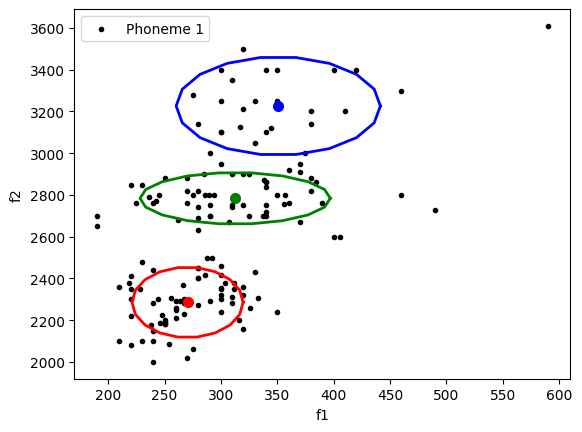


Finished.

[[ 270.3952  2285.4653 ]
 [ 312.59125 2783.898  ]
 [ 350.8446  3226.3394 ]] [[[ 1213.73843436     0.        ]
  [    0.         14278.42049004]]

 [[ 3562.59748189     0.        ]
  [    0.          7657.84634782]]

 [[ 4102.87482233     0.        ]
  [    0.         27829.57494757]]]


(array([[ 270.4 , 2285.47],
        [ 312.59, 2783.9 ],
        [ 350.84, 3226.34]], dtype=float32),
 array([[[ 1213.74,     0.  ],
         [    0.  , 14278.42]],
 
        [[ 3562.6 ,     0.  ],
         [    0.  ,  7657.85]],
 
        [[ 4102.87,     0.  ],
         [    0.  , 27829.57]]]),
 array([0.44, 0.38, 0.18]))

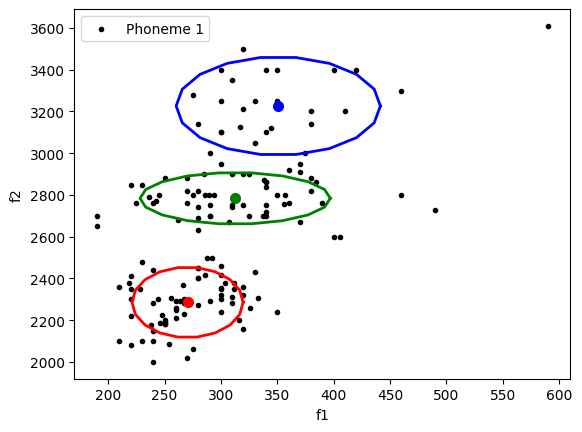

In [8]:
k = 3
# id of the phoneme that will be used (e.g. 1, or 2)
p_id = 1    
X_full = np.zeros((len(f1), 2))
X_full[:,0] = f1.copy()
X_full[:,1] = f2.copy()
X_full = X_full.astype(np.float32) 

train_gmm( X_full, k= 3, p_id=1, save= False) 

####  Below we run the EM algorithm with 100 iterations, 10 times and appending each models parameters in a table named res_tbl

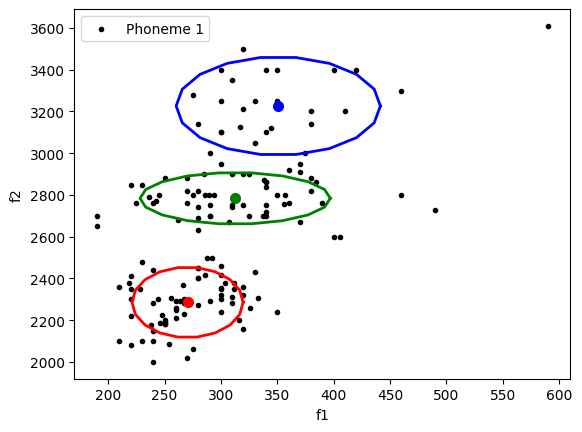


Finished.

[[ 270.3952  2285.4653 ]
 [ 312.59125 2783.898  ]
 [ 350.8446  3226.3394 ]] [[[ 1213.73843493     0.        ]
  [    0.         14278.42030622]]

 [[ 3562.59743837     0.        ]
  [    0.          7657.84892961]]

 [[ 4102.87536749     0.        ]
  [    0.         27829.54265532]]]


,mu,s,p
0,"[[350.84, 3226.34], [270.4, 2285.47], [312.59, 2783.9]]","[[[4102.87, 0.0], [0.0, 27829.58]], [[1213.74, 0.0], [0.0, 14278.42]], [[3562.6, 0.0], [0.0, 7657.85]]]","[0.18, 0.44, 0.38]"
1,"[[268.81, 2277.12], [323.34, 2900.94], [268.81, 2277.12]]","[[[1184.78, 0.0], [0.0, 13657.88]], [[3964.44, 0.0], [0.0, 68344.91]], [[1184.78, 0.0], [0.0, 13657.88]]]","[0.2, 0.6, 0.2]"
2,"[[350.84, 3226.34], [270.4, 2285.47], [312.59, 2783.9]]","[[[4102.86, 0.0], [0.0, 27830.13]], [[1213.74, 0.0], [0.0, 14278.42]], [[3562.6, 0.0], [0.0, 7657.79]]]","[0.18, 0.44, 0.38]"
3,"[[312.59, 2783.9], [350.84, 3226.34], [270.4, 2285.47]]","[[[3562.6, 0.0], [0.0, 7657.85]], [[4102.88, 0.0], [0.0, 27829.54]], [[1213.74, 0.0], [0.0, 14278.42]]]","[0.38, 0.18, 0.44]"
4,"[[350.84, 3226.34], [312.59, 2783.9], [270.4, 2285.47]]","[[[4102.86, 0.0], [0.0, 27830.34]], [[3562.6, 0.0], [0.0, 7657.77]], [[1213.74, 0.0], [0.0, 14278.42]]]","[0.18, 0.38, 0.44]"
5,"[[270.4, 2285.47], [312.59, 2783.9], [350.84, 3226.34]]","[[[1213.74, 0.0], [0.0, 14278.42]], [[3562.6, 0.0], [0.0, 7657.85]], [[4102.88, 0.0], [0.0, 27829.54]]]","[0.44, 0.38, 0.18]"
6,"[[312.59, 2783.89], [270.4, 2285.47], [350.84, 3226.32]]","[[[3562.61, 0.0], [0.0, 7657.37]], [[1213.74, 0.0], [0.0, 14278.43]], [[4102.78, 0.0], [0.0, 27834.52]]]","[0.38, 0.44, 0.18]"
7,"[[350.84, 3226.34], [270.4, 2285.47], [312.59, 2783.9]]","[[[4102.87, 0.0], [0.0, 27829.6]], [[1213.74, 0.0], [0.0, 14278.42]], [[3562.6, 0.0], [0.0, 7657.84]]]","[0.18, 0.44, 0.38]"
8,"[[350.84, 3226.34], [312.59, 2783.9], [270.4, 2285.47]]","[[[4102.87, 0.0], [0.0, 27829.64]], [[3562.6, 0.0], [0.0, 7657.84]], [[1213.74, 0.0], [0.0, 14278.42]]]","[0.18, 0.38, 0.44]"
9,"[[270.4, 2285.47], [312.59, 2783.9], [350.84, 3226.34]]","[[[1213.74, 0.0], [0.0, 14278.42]], [[3562.6, 0.0], [0.0, 7657.85]], [[4102.88, 0.0], [0.0, 27829.54]]]","[0.44, 0.38, 0.18]"


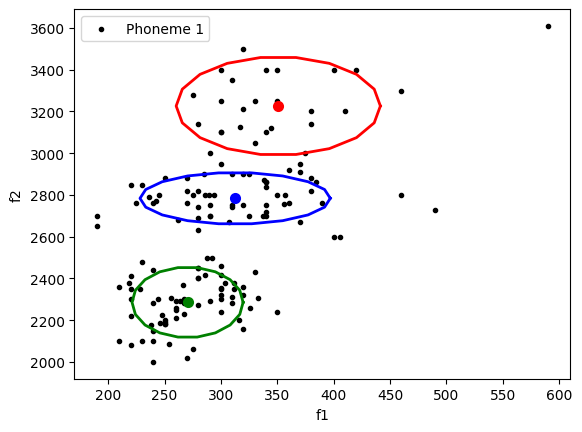

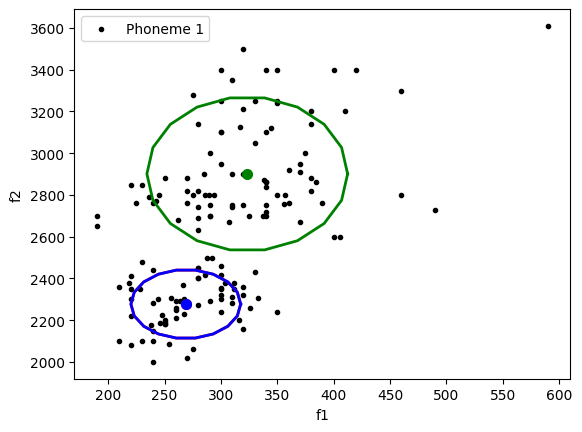

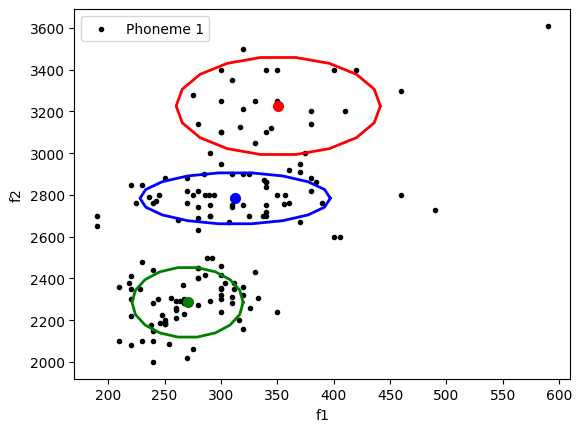

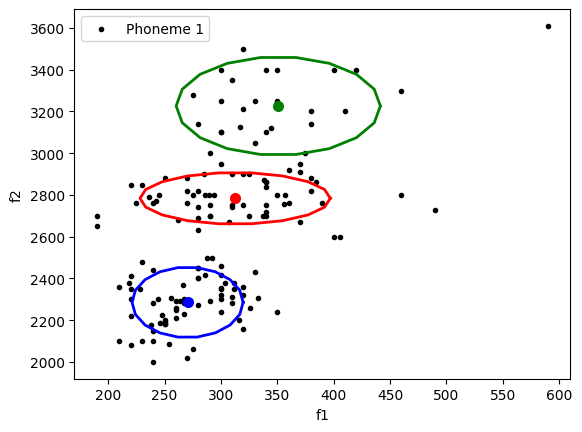

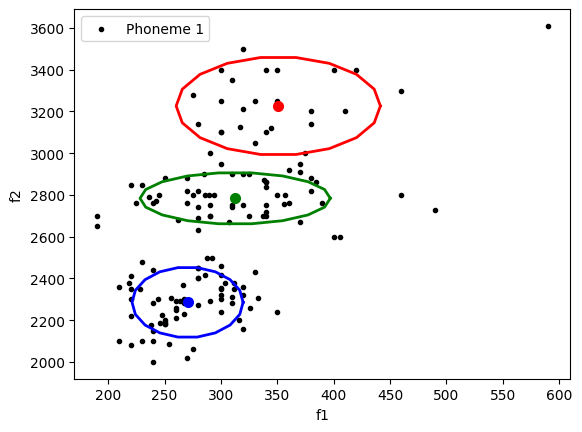

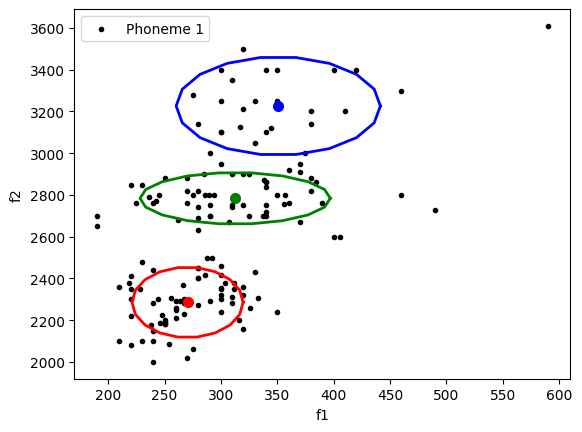

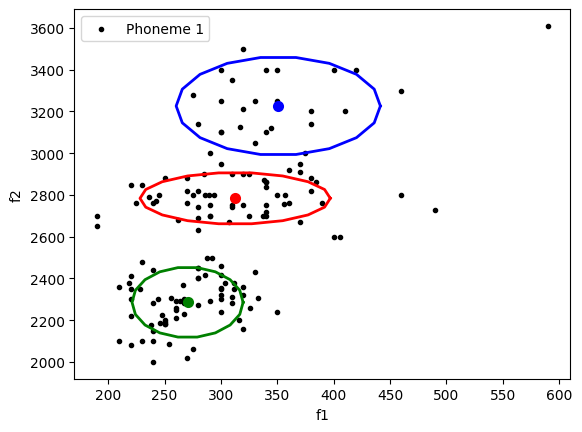

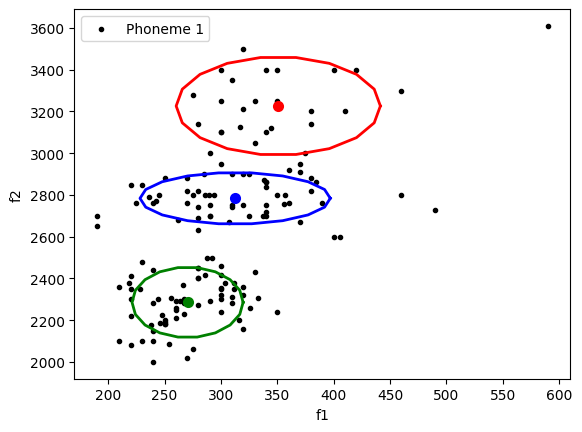

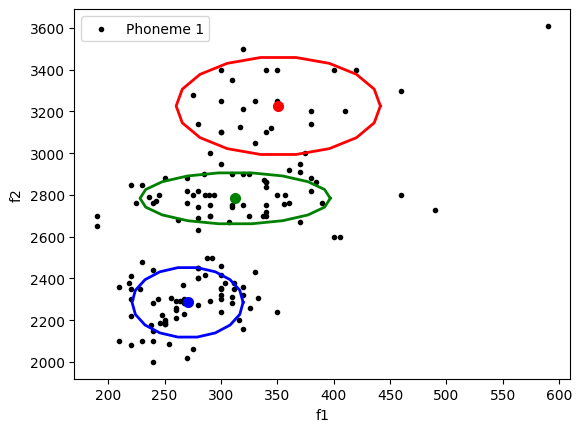

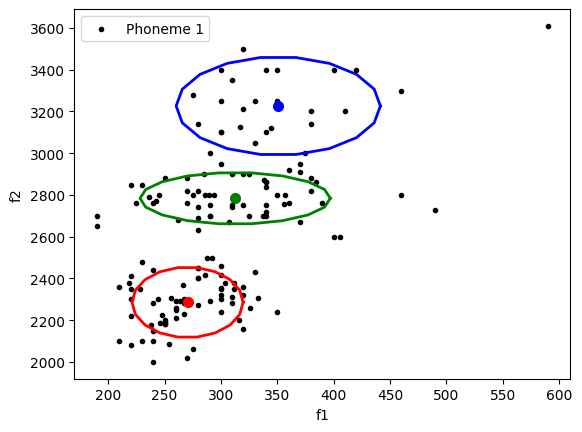

In [9]:
pd.set_option('display.max_colwidth', None)

results = []
n_trials = 10

for i in range(n_trials):
 
    mu, s, p= train_gmm( X_full, k= 3, p_id= p_id, save= False)
    results.append((mu, s, p))

res_tbl = pd.DataFrame( results, columns= ['mu','s', 'p'] )
res_tbl

#### Repeating the training for phoneme_id = 2 


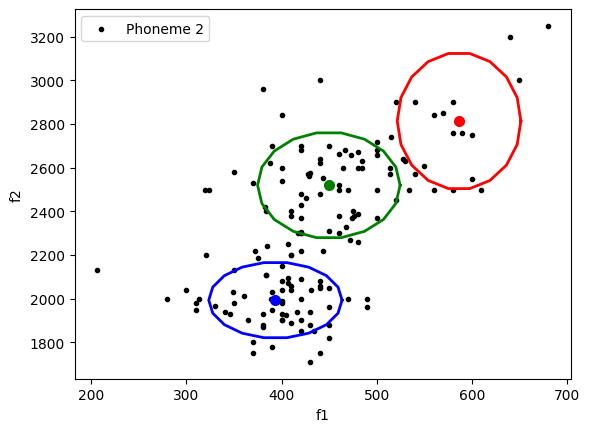


Finished.

[[ 586.5284  2814.0464 ]
 [ 449.6589  2519.6455 ]
 [ 393.45123 1993.0659 ]] [[[ 2112.54471445     0.        ]
  [    0.         49424.50233128]]

 [[ 2808.12155473     0.        ]
  [    0.         29724.19080757]]

 [[ 2454.99636245     0.        ]
  [    0.         15260.48507108]]]


(array([[ 586.53, 2814.05],
        [ 449.66, 2519.65],
        [ 393.45, 1993.07]], dtype=float32),
 array([[[ 2112.54,     0.  ],
         [    0.  , 49424.5 ]],
 
        [[ 2808.12,     0.  ],
         [    0.  , 29724.19]],
 
        [[ 2455.  ,     0.  ],
         [    0.  , 15260.49]]]),
 array([0.09, 0.47, 0.44]))

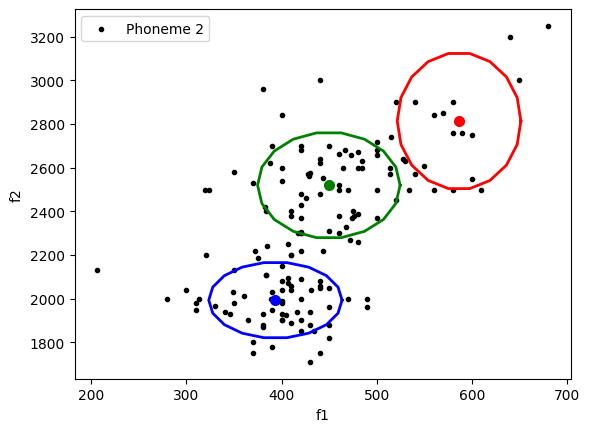

In [10]:
train_gmm( X_full, k= 3, p_id= 2, save= False)

### Training for $K=6$ for phoneme_id =1 and phoneme_id=2  

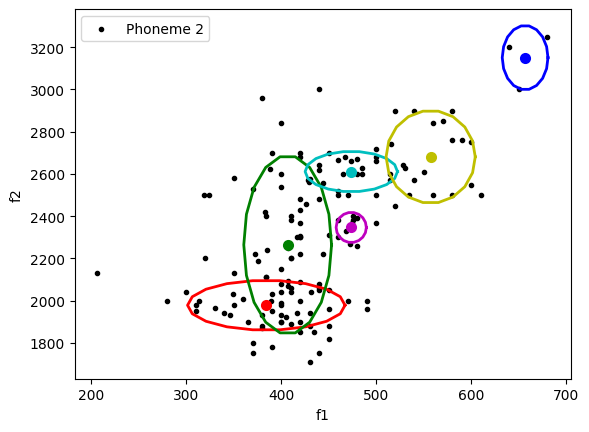


Finished.

[[ 384.1756  1978.3433 ]
 [ 406.69672 2264.3635 ]
 [ 656.7028  3150.7283 ]
 [ 473.6957  2611.3047 ]
 [ 473.62207 2346.7043 ]
 [ 557.273   2680.8972 ]] [[[ 3436.64533742     0.        ]
  [    0.          6963.94338943]]

 [[ 1067.99862957     0.        ]
  [    0.         89587.99299322]]

 [[  290.10891877     0.        ]
  [    0.         11614.94943379]]

 [[ 1182.31323862     0.        ]
  [    0.          4576.93448935]]

 [[  126.59949467     0.        ]
  [    0.          2555.0587711 ]]

 [[ 1101.99215003     0.        ]
  [    0.         24118.84002819]]]


(array([[ 384.18, 1978.34],
        [ 406.7 , 2264.36],
        [ 656.7 , 3150.73],
        [ 473.7 , 2611.3 ],
        [ 473.62, 2346.7 ],
        [ 557.27, 2680.9 ]], dtype=float32),
 array([[[ 3436.65,     0.  ],
         [    0.  ,  6963.94]],
 
        [[ 1068.  ,     0.  ],
         [    0.  , 89587.99]],
 
        [[  290.11,     0.  ],
         [    0.  , 11614.95]],
 
        [[ 1182.31,     0.  ],
         [    0.  ,  4576.93]],
 
        [[  126.6 ,     0.  ],
         [    0.  ,  2555.06]],
 
        [[ 1101.99,     0.  ],
         [    0.  , 24118.84]]]),
 array([0.25, 0.4 , 0.02, 0.15, 0.06, 0.12]))

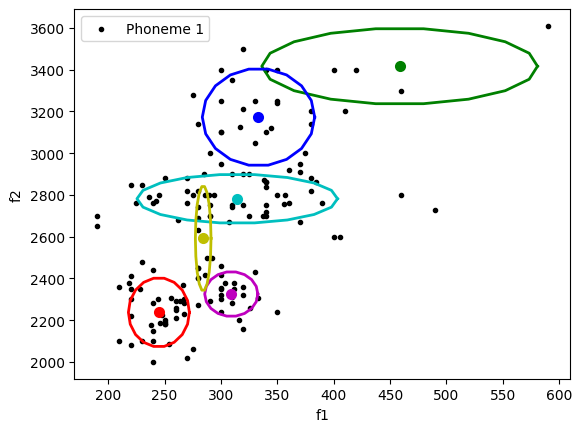

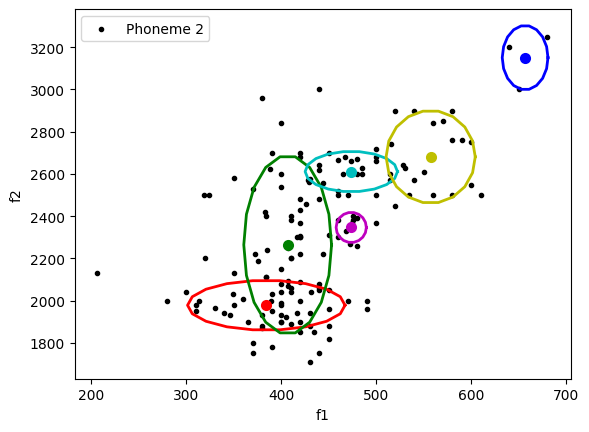

In [11]:
train_gmm( X_full, k= 6, p_id= 1, save= False)
train_gmm( X_full, k= 6, p_id= 2, save= False)

### Using the 2 MoGs ($K=3$) learnt previously, we build a classifier to discriminate between phonemes 1 and 2 

Classifying using the Maximum Likelihood (ML) criterion and calculating the miss-classification error. A classification under the ML compares $p(\mathbf{x};\boldsymbol\theta_{1})$, where $\boldsymbol\theta_{1}$ are the parameters of the MoG learnt for the first phoneme, with $p(\mathbf{x};\boldsymbol\theta_{2})$, where $\boldsymbol\theta_{2}$  are the parameters of the MoG learnt for the second phoneme.

In [12]:
inds_1 = np.where(phoneme_id==1)
inds_2 = np.where(phoneme_id==2)
inds_1 = inds_1[0]
inds_2 = inds_2[0]
inds_1_and_2 = np.concatenate((inds_1, inds_2), axis=0)

X = X_full[inds_1_and_2,:]

In [13]:
N = X.shape[0]
D = X.shape[1]
k = 3

# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 1
p_id = 1
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_1 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_1 = np.ndarray.tolist(GMM_parameters_phoneme_1)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_1['mu']
s = GMM_parameters_phoneme_1['s']
p = GMM_parameters_phoneme_1['p']

# Initialize array Z_1 that will get the predictions of each Gaussian on each sample
Z_1 = np.zeros((N,k)) # shape Nxk

# get predictions
Z_1 = get_predictions(mu, s, p ,X) 


# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 2
p_id = 2
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)

if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_2 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_2 = np.ndarray.tolist(GMM_parameters_phoneme_2)
else:
    raise('File {} does not exist.'.format(npy_filename))

mu = GMM_parameters_phoneme_2['mu']
s = GMM_parameters_phoneme_2['s']
p = GMM_parameters_phoneme_2['p']

Z_2 = get_predictions(mu, s, p ,X)  
 
# Get total likelihoods for each phoneme
P_phoneme_1 = np.sum(Z_1, axis=1)  # shape: (N,)
P_phoneme_2 = np.sum(Z_2, axis=1)  # shape: (N,)

 
# classify each point using Maximum Likelihood
p_j = np.array([len(inds_1) , len(inds_2)]) / N
y_preds_3 = np.where(P_phoneme_1 * p_j[0] > P_phoneme_2 * p_j[1], 1, 2)
y_3 = data['phoneme_id'][inds_1_and_2]
 
# calculate accuracy
miss_classification_error = np.mean(y_preds_3 != y_3)   

print(f"Accuracy: { (1-miss_classification_error) * 100:.2f}%")
print(f"Miss-classification Error: {miss_classification_error * 100:.2f}%")
 

Accuracy: 95.07%
Miss-classification Error: 4.93%


#### Repeating for $K=6$ and comparing the results 

In [14]:
N = X.shape[0]
D = X.shape[1]
k = 6


# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 1
p_id = 1
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_1 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_1 = np.ndarray.tolist(GMM_parameters_phoneme_1)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_1['mu']
s = GMM_parameters_phoneme_1['s']
p = GMM_parameters_phoneme_1['p']


# Initialize array Z_1 that will get the predictions of each Gaussian on each sample
Z_1 = np.zeros((N,k)) # shape Nxk
# get predictions
Z_1 = get_predictions(mu, s, p ,X) 



# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 2
p_id = 2
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)

if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_2 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_2 = np.ndarray.tolist(GMM_parameters_phoneme_2)
else:
    raise('File {} does not exist.'.format(npy_filename))

mu = GMM_parameters_phoneme_2['mu']
s = GMM_parameters_phoneme_2['s']
p = GMM_parameters_phoneme_2['p']

Z_2 = get_predictions(mu, s, p ,X)  
 
# Get total likelihoods for each phoneme
P_phoneme_1 = np.sum(Z_1, axis=1)  # shape: (N,)
P_phoneme_2 = np.sum(Z_2, axis=1)  # shape: (N,)

 
 
# classify each point using Maximum Likelihood
p_j = np.array([len(inds_1) , len(inds_2)]) / N
y_preds_3 = np.where(P_phoneme_1 * p_j[0] > P_phoneme_2 * p_j[1], 1, 2)
y_3 = data['phoneme_id'][inds_1_and_2]
 
# calculate accuracy
miss_classification_error = np.mean(y_preds_3 != y_3)   

print(f"Accuracy: { (1-miss_classification_error) * 100:.2f}%")
print(f"Miss-classification Error: {miss_classification_error * 100:.2f}%")
 

Accuracy: 96.05%
Miss-classification Error: 3.95%


### Below we display a "classification matrix" assigning labels to a grid of all combinations of the $F1$ and $F2$ features for the $K=3$ classifiers from above. Next, we repeat this step for $K=6$ and comparing the two.

In particular, we
create a custom uniform grid of points that spans all possible intermediate combinations of $F1$ and $F2$ features, using the features' minimum and maximum values as the limits. 
We then classify each point in the grid using one of your classifiers. That is, create a classification matrix, $\mathbf{M}$, whose elements are either 0 or 1. $M(i,j)$ is 0 if the point at location $(i,j)$ on the custom grid is classified as belonging to phoneme 1, and is 1 otherwise.


Assuming our data were the orange points below, the custom grid would look something like the following (evenly spaced points spanning the minimum to maximum values of both features):

![](https://i.imgur.com/khfYx42.png)



In [15]:
X = X_full[inds_1_and_2,:]
 
min_f1 = int(np.min(X[:,0]))
max_f1 = int(np.max(X[:,0]))
min_f2 = int(np.min(X[:,1]))
max_f2 = int(np.max(X[:,1]))
N_f1 = max_f1 - min_f1
N_f2 = max_f2 - min_f2
print('f1 range: {}-{} | {} points'.format(min_f1, max_f1, N_f1))
print('f2 range: {}-{} | {} points'.format(min_f2, max_f2, N_f2))


f1 range: 190-680 | 490 points
f2 range: 1710-3610 | 1900 points


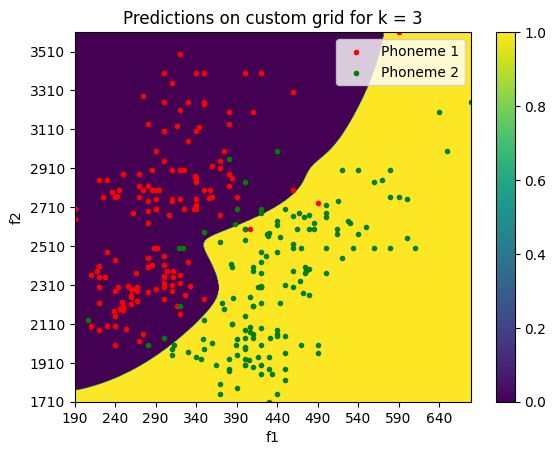

In [16]:
'''

Creating a custom grid of shape N_f1 x N_f2
The grid will span all the values of (f1, f2) pairs, between [min_f1, max_f1] on f1 axis, and between [min_f2, max_f2] on f2 axis
Then, classifies each point [i.e., each (f1, f2) pair] of that grid, to either phoneme 1, or phoneme 2, using the two trained GMMs
Predicts using GMM trained on phoneme 1, on custom grid
Predicts using GMM trained on phoneme 2, on custom grid
Compares these predictions, to classify each point of the grid
Stores these predictions in a 2D numpy array named "M", of shape N_f2 x N_f1 (the first dimension is f2 so that we keep f2 in the vertical axis of the plot)
M contains "0.0" in the points that belong to phoneme 1 and "1.0" in the points that belong to phoneme 2


'''

f1_points = np.linspace(min_f1, max_f1, N_f1)
f2_points = np.linspace(min_f2, max_f2, N_f2)


xv, yv = np.meshgrid(f1_points, f2_points)
X_grid = np.array([xv.reshape(N_f1*N_f2) , yv.reshape(N_f1*N_f2)] ).T  



N = X_grid.shape[0]
D = X_grid.shape[1]
k = 3

# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 1
p_id = 1
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_1 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_1 = np.ndarray.tolist(GMM_parameters_phoneme_1)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_1['mu']
s = GMM_parameters_phoneme_1['s']
p = GMM_parameters_phoneme_1['p']
Z_phoneme_1 = get_predictions(mu, s, p ,X_grid) 


# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 2
p_id = 2
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)

if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_2 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_2 = np.ndarray.tolist(GMM_parameters_phoneme_2)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_2['mu']
s = GMM_parameters_phoneme_2['s']
p = GMM_parameters_phoneme_2['p']
Z_phoneme_2 = get_predictions(mu, s, p ,X_grid)  
 

# classify each point using Maximum Likelihood
P_phoneme_1 = np.sum(Z_phoneme_1, axis=1)  # shape: (N,)
P_phoneme_2 = np.sum(Z_phoneme_2, axis=1)  # shape: (N,)

p_j = np.array([len(inds_1) , len(inds_2)]) / N
y_preds = np.where(P_phoneme_1 * p[0] > P_phoneme_2 * p[1], 0, 1) 

M = y_preds.reshape((N_f2,N_f1))
 
# Visualize predictions on custom grid 
fig, ax = plt.subplots()
 
plt.imshow(M, aspect='auto')
 
ax.set_xlabel('f1') 
ax.set_ylabel('f2')
 
plt.xlim((0, N_f1))
plt.ylim((0, N_f2))
 
x_range = np.arange(0, N_f1, step=50)
x_strings = [str(x+min_f1) for x in x_range]
plt.xticks(x_range, x_strings)
y_range = np.arange(0, N_f2, step=200)
y_strings = [str(y+min_f2) for y in y_range]
plt.yticks(y_range, y_strings)
 
title_string = f'Predictions on custom grid for k = {k}'
plt.title(title_string) 
plt.colorbar()

N_samples = int(X.shape[0]/2)
plt.scatter(X[:N_samples, 0] - min_f1, X[:N_samples, 1] - min_f2, marker='.', color='red', label='Phoneme 1')
plt.scatter(X[N_samples:, 0] - min_f1, X[N_samples:, 1] - min_f2, marker='.', color='green', label='Phoneme 2')
 
plt.legend()
plt.show()

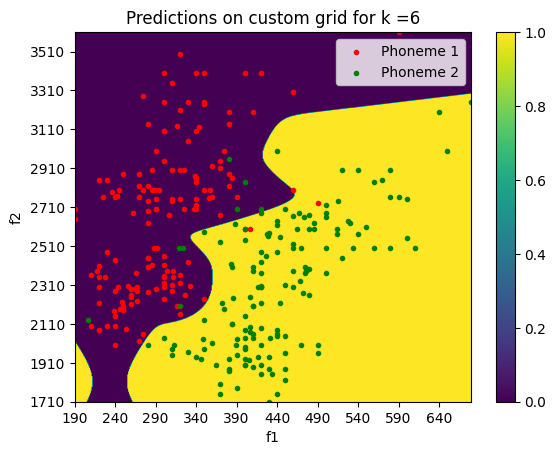

In [17]:
# Same for k=6
f1_points = np.linspace(min_f1, max_f1, N_f1)
f2_points = np.linspace(min_f2, max_f2, N_f2)


xv, yv = np.meshgrid(f1_points, f2_points)
X_grid = np.array([xv.reshape(N_f1*N_f2) , yv.reshape(N_f1*N_f2)] ).T  



N = X_grid.shape[0]
D = X_grid.shape[1]
k = 6

# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 1
p_id = 1
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_1 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_1 = np.ndarray.tolist(GMM_parameters_phoneme_1)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_1['mu']
s = GMM_parameters_phoneme_1['s']
p = GMM_parameters_phoneme_1['p']
Z_phoneme_1 = get_predictions(mu, s, p ,X_grid) 


# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 2
p_id = 2
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)

if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_2 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_2 = np.ndarray.tolist(GMM_parameters_phoneme_2)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_2['mu']
s = GMM_parameters_phoneme_2['s']
p = GMM_parameters_phoneme_2['p']
Z_phoneme_2 = get_predictions(mu, s, p ,X_grid)  
 

# classify each point using Maximum Likelihood
P_phoneme_1 = np.sum(Z_phoneme_1, axis=1)  # shape: (N,)
P_phoneme_2 = np.sum(Z_phoneme_2, axis=1)  # shape: (N,)

p_j = np.array([len(inds_1) , len(inds_2)]) / N
y_preds = np.where(P_phoneme_1 * p[0] > P_phoneme_2 * p[1], 0, 1) 

M = y_preds.reshape((N_f2,N_f1)) 


# Visualize predictions on custom grid 
fig, ax = plt.subplots() 
plt.imshow(M, aspect='auto')
 
ax.set_xlabel('f1') 
ax.set_ylabel('f2') 
plt.xlim((0, N_f1))
plt.ylim((0, N_f2))
 
x_range = np.arange(0, N_f1, step=50)
x_strings = [str(x+min_f1) for x in x_range]
plt.xticks(x_range, x_strings)
y_range = np.arange(0, N_f2, step=200)
y_strings = [str(y+min_f2) for y in y_range]
plt.yticks(y_range, y_strings)
 
title_string = f'Predictions on custom grid for k ={k}'
plt.title(title_string) 
plt.colorbar()

N_samples = int(X.shape[0]/2)
plt.scatter(X[:N_samples, 0] - min_f1, X[:N_samples, 1] - min_f2, marker='.', color='red', label='Phoneme 1')
plt.scatter(X[N_samples:, 0] - min_f1, X[N_samples:, 1] - min_f2, marker='.', color='green', label='Phoneme 2')
 
plt.legend()
plt.show()

We create a new dataset that will contain 3 columns, as follows:
\begin{equation}
    X = [F1, F2, F1+F2]
\end{equation}

#### We try to fit a MoG model to the new data and observe failure due to perfect multicollinearity between the features 

In [18]:
p_id = 1 # id of the phoneme that will be used (e.g. 1, or 2)

k = 3 # number of GMM components
X = np.zeros((len(f1), 3)) 


X = np.hstack((X_full,X_full.sum(axis=1).reshape(-1, 1)))
inds_1 = np.where(phoneme_id == p_id) 
X = X[inds_1,:].squeeze() 
assert (X[:,0] + X[:,1] == X[:,2]).all()
print(X.shape)  

(152, 3)


Iteration 001/150
Iteration 002/150
Iteration 003/150
Iteration 004/150
Iteration 005/150
Iteration 006/150
Iteration 007/150
Iteration 008/150
Iteration 009/150
Iteration 010/150
Iteration 011/150
Iteration 012/150
Iteration 013/150
Iteration 014/150
Iteration 015/150
Iteration 016/150
Iteration 017/150
Iteration 018/150
Iteration 019/150
Iteration 020/150
Iteration 021/150
Iteration 022/150
Iteration 023/150
Iteration 024/150
Iteration 025/150
Iteration 026/150
Iteration 027/150
Iteration 028/150
Iteration 029/150
Iteration 030/150
Iteration 031/150
Iteration 032/150
Iteration 033/150
Iteration 034/150
Iteration 035/150
Iteration 036/150
Iteration 037/150
Iteration 038/150
Iteration 039/150
Iteration 040/150
Iteration 041/150
Iteration 042/150
Iteration 043/150
Iteration 044/150
Iteration 045/150
Iteration 046/150
Iteration 047/150
Iteration 048/150
Iteration 049/150
Iteration 050/150


C:\Users\ec24106\AppData\Local\Temp\ipykernel_6320\3665357362.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  Z[:, i] = p[i]*(1/np.power(((2*np.pi)**D) * np.abs(s_i_det), 0.5)) * np.exp(-0.5*np.sum(x_s_x, axis=1))


ValueError: Input contains infinity or a value too large for dtype('float64').

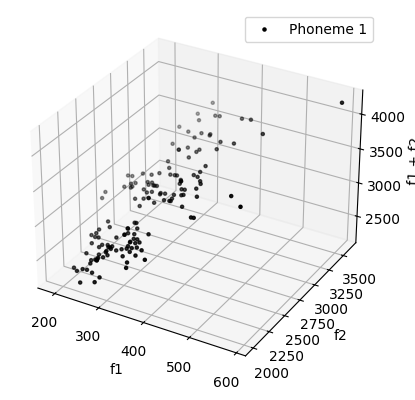

In [19]:
fig = plt.figure()
ax1 = plt.axes(projection='3d')
title_string = 'Phoneme {}'.format(p_id)
plot_data_3D(X=X, title_string=title_string, ax=ax1)

N, D = X.shape
p = np.ones((k))/k
random_indices = np.floor(N*np.random.rand((k)))
random_indices = random_indices.astype(int)
mu = X[random_indices,:] # shape kxD
s = np.zeros((k,D,D)) # shape kxDxD
n_iter = 150

# initialize covariances
for i in range(k):
    cov_matrix = np.cov(X.transpose())
    s[i,:,:] = cov_matrix/k

Z = np.zeros((N,k)) # shape Nxk

###############################
# run Expectation Maximization algorithm for n_iter iterations
for t in range(n_iter):
    #print('****************************************')
    print('Iteration {:03}/{:03}'.format(t+1, n_iter))

    # Do the E-step
    Z = get_predictions(mu, s, p, X)
    Z = normalize(Z, axis=1, norm='l1')
    # Do the M-step:
    for i in range(k):
        mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])

        ###################################################
        # We will fit Gaussians with full covariance matrices:
        mu_i = mu[i,:]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)

        term_1 = X.transpose() - mu_i_repeated
        term_2 = np.repeat(np.expand_dims(Z[:,i], axis=1), D, axis=1) * term_1.transpose()
        s[i,:,:] = np.matmul(term_1, term_2)/np.sum(Z[:,i])
        p[i] = np.mean(Z[:,i])

plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
plt.show()

### We implement two ways of overcoming the singularity problem:

#### For this first implementation we just standardize the data and run the rest of the algorithm as provided

In [20]:
p_id = 1 # id of the phoneme that will be used (e.g. 1, or 2)
k = 3 # number of GMM components
X = np.zeros((len(f1), 3))

X = np.hstack((X_full,X_full.sum(axis=1).reshape(-1, 1)))
inds_1 = np.where(phoneme_id == p_id) 
X = X[inds_1,:].squeeze() 

assert (X[:,0] + X[:,1] == X[:,2]).all()
print(X.shape) 

# Apply Standardization to the data 
X = StandardScaler().fit_transform(X) 
X.mean(axis= 0), X.std(axis= 0)

(152, 3)


(array([ 7.6466485e-08, -8.5485610e-08, -1.2548346e-08], dtype=float32),
 array([1.       , 1.0000001, 1.       ], dtype=float32))

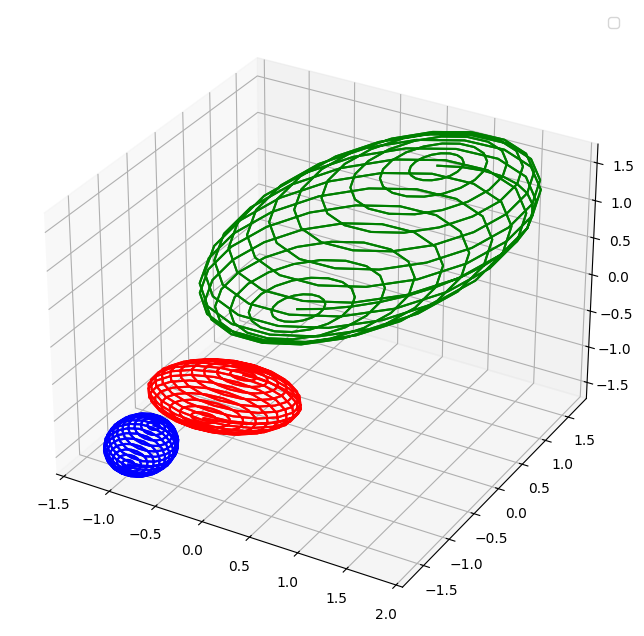

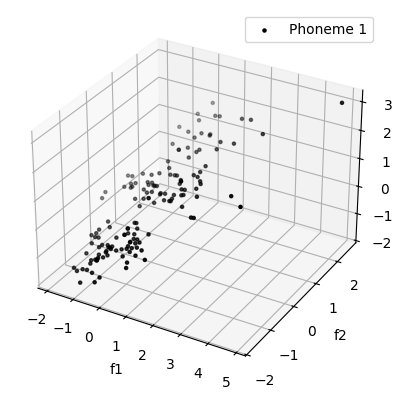

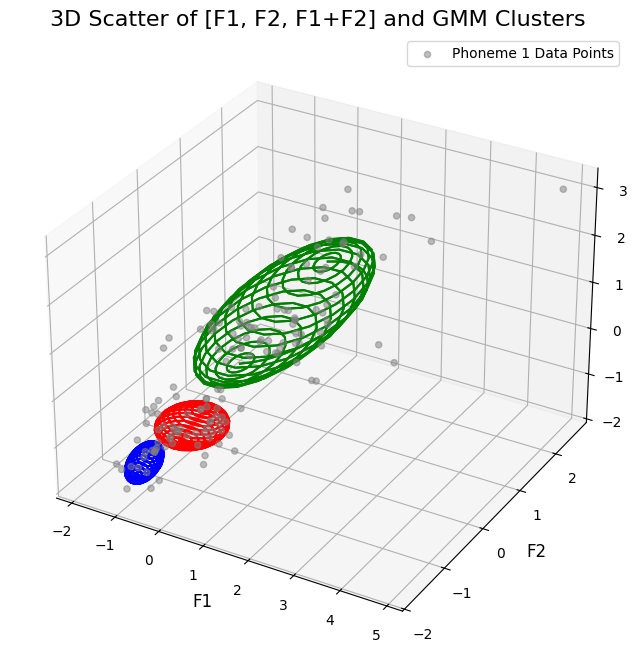

In [21]:
#########################################
fig = plt.figure()
ax1 = plt.axes(projection='3d')
title_string = 'Phoneme {}'.format(p_id)
plot_data_3D(X=X, title_string=title_string, ax=ax1)

N, D = X.shape
p = np.ones((k))/k
random_indices = np.floor(N*np.random.rand((k)))
random_indices = random_indices.astype(int)
mu = X[random_indices,:] # shape kxD
s = np.zeros((k,D,D)) # shape kxDxD
n_iter = 150

# initialize covariances
for i in range(k):
    cov_matrix = np.cov(X.transpose())
    s[i,:,:] = cov_matrix/k
Z = np.zeros((N,k)) # shape Nxk


###############################
# run Expectation Maximization algorithm for n_iter iterations
for t in range(n_iter):
    #print('****************************************')
    print('Iteration {:03}/{:03}'.format(t+1, n_iter))

    # Do the E-step
    Z = get_predictions(mu, s, p, X)
    Z = normalize(Z, axis=1, norm='l1')
    # Do the M-step:
    for i in range(k):
        mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])

        ###################################################
        # We will fit Gaussians with full covariance matrices:
        mu_i = mu[i,:]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)

        term_1 = X.transpose() - mu_i_repeated
        term_2 = np.repeat(np.expand_dims(Z[:,i], axis=1), D, axis=1) * term_1.transpose()
        s[i,:,:] = np.matmul(term_1, term_2)/np.sum(Z[:,i])

        p[i] = np.mean(Z[:,i])


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c='gray', alpha=0.5, s=20, label= f'Phoneme {p_id} Data Points')

# Adding title and axis labels
ax1.set_title('3D Scatter of [F1, F2, F1+F2] and GMM Clusters', fontsize=16)
ax1.set_xlabel('F1', fontsize=12)
ax1.set_ylabel('F2', fontsize=12)
ax1.set_zlabel('F1+F2', fontsize=12)

# Adding legend
ax1.legend()  
plt.show()

### For this second implementation we wanted to take our algorithm a step further and therefore implemented a very robust solution in order to make sure that our model converged optimally every time

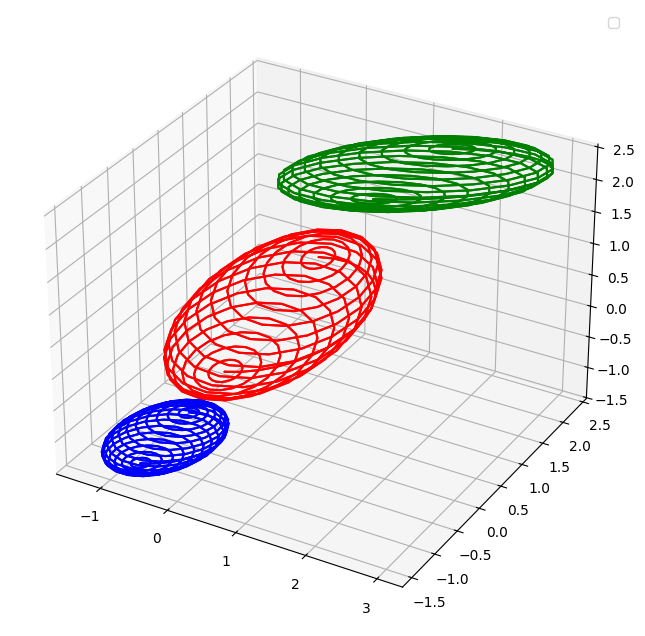

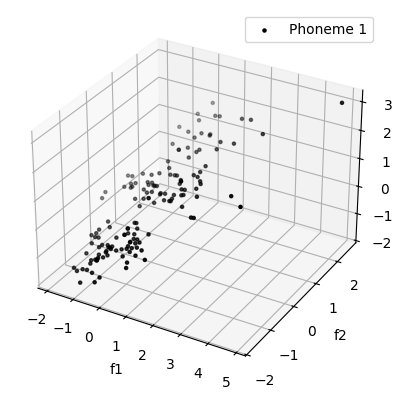

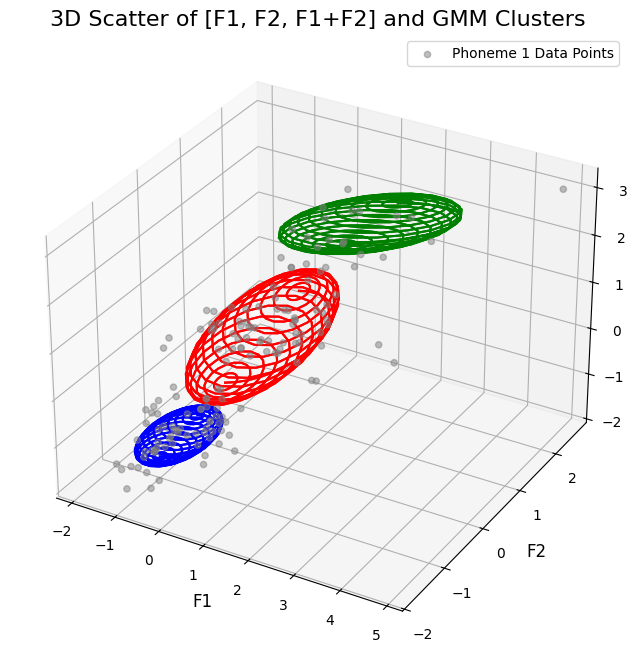

In [22]:
#########################################
fig = plt.figure()
ax1 = plt.axes(projection='3d')
title_string = 'Phoneme {}'.format(p_id)
plot_data_3D(X=X, title_string=title_string, ax=ax1)

N, D = X.shape
p = np.ones((k))/k
random_indices = np.floor(N*np.random.rand((k)))
random_indices = random_indices.astype(int)
mu = X[random_indices,:] # shape kxD
s = np.zeros((k,D,D)) # shape kxDxD
s0 = 1e-5
s0_mat = s0 * np.eye(k)
n_iter = 150

kmeans = KMeans(n_clusters= k, random_state=42)
mu = kmeans.fit(X).cluster_centers_

# initialize covariances
for i in range(k):
    cov_matrix = np.cov(X.transpose())
    s[i,:,:] = cov_matrix/k
Z = np.zeros((N,k)) # shape Nxk


###############################
# run Expectation Maximization algorithm for n_iter iterations
for t in range(n_iter):
    #print('****************************************')
    print('Iteration {:03}/{:03}'.format(t+1, n_iter))

    # Do the E-step
    Z = get_predictions(mu, s, p, X)
    Z = normalize(Z, axis=1, norm='l1')
    # Do the M-step:
    for i in range(k):
        mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])

        ###################################################
        # We will fit Gaussians with full covariance matrices:
        mu_i = mu[i,:]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)

        term_1 = X.transpose() - mu_i_repeated
        term_2 = np.repeat(np.expand_dims(Z[:,i], axis=1), D, axis=1) * term_1.transpose()
        s[i,:,:] = np.matmul(term_1, term_2)/np.sum(Z[:,i])

        if scipy.linalg.det(s[i,:,:]) == 0:
             s[i,:,:] += s0_mat

        p[i] = np.mean(Z[:,i])


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c='gray', alpha=0.5, s=20, label= f'Phoneme {p_id} Data Points')

# Adding title and axis labels
ax1.set_title('3D Scatter of [F1, F2, F1+F2] and GMM Clusters', fontsize=16)
ax1.set_xlabel('F1', fontsize=12)
ax1.set_ylabel('F2', fontsize=12)
ax1.set_zlabel('F1+F2', fontsize=12)

# Adding legend
ax1.legend()  
plt.show()